# Fama-French Three-Factor Model

Reference: https://sec-api.io/resources/fama-french-factor-model

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf
import os

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True,  "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [10]:
ticker = "QQQ"
start_date = "2006-01-01"
end_date = "2023-12-31"

[*********************100%***********************]  1 of 1 completed


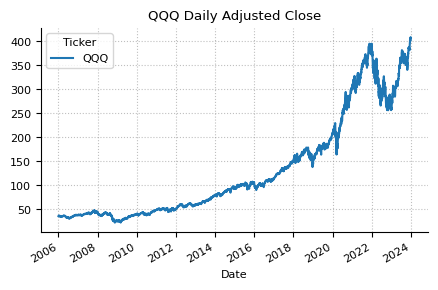

In [11]:
# Use Yahoo Finance to download historical data for the specified ticker
daily = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
daily["Adj Close"].plot(title=f"{ticker} Daily Adjusted Close", figsize=(5, 3))
plt.show()

In [12]:
# Calculate monthly returns of ticker
monthly = daily["Adj Close"].resample("ME").ffill()
monthly.index = monthly.index.to_period("M")
monthly["Return"] = monthly.pct_change() * 100
monthly.dropna(inplace=True)
monthly

Ticker,QQQ,Return
Date,,
2006-02,35.303074,-2.142898
2006-03,36.041264,2.091007
2006-04,35.972504,-0.190781
2006-05,33.368046,-7.240135
2006-06,33.347515,-0.061528
...,...,...
2023-08,373.711731,-1.482994
2023-09,354.727692,-5.079862
2023-10,347.400848,-2.065484


In [13]:
# Step 2: Load the monthly three factors into a dataframe
# CSV columns: , Mkt-RF, SMB, HML, RF
# The first columns represents the date
# The first row contains the column names
ff_factors_monthly = pd.read_csv(os.path.join(os.getcwd(), "data", "F-F_Research_Data_Factors.CSV"), index_col=0)
ff_factors_monthly.index.names = ["Date"]
ff_factors_monthly.index = pd.to_datetime(ff_factors_monthly.index, format="%Y%m")
ff_factors_monthly.index = ff_factors_monthly.index.to_period("M")
ff_factors_monthly

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2023-08,-2.39,-3.20,-1.08,0.45
2023-09,-5.24,-2.49,1.45,0.43
2023-10,-3.18,-3.88,0.19,0.47


In [14]:
# Filter factor dates to match the asset
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(monthly.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = monthly["Return"] - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2006-02,-0.30,-0.38,-0.34,0.34,-2.482898
2006-03,1.46,3.44,0.60,0.37,1.721007
2006-04,0.73,-1.42,2.34,0.36,-0.550781
2006-05,-3.57,-2.96,2.41,0.43,-7.670135
2006-06,-0.35,-0.39,0.85,0.40,-0.461528
...,...,...,...,...,...
2023-08,-2.39,-3.20,-1.08,0.45,-1.932994
2023-09,-5.24,-2.49,1.45,0.43,-5.509862
2023-10,-3.18,-3.88,0.19,0.47,-2.535484


In [15]:
import statsmodels.api as sm

# Prepare the independent variables (add a constant to the model)
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
# The dependent variable
y = ff_factors_subset["Excess_Return"]
# Run the regression
model = sm.OLS(y, X).fit()
# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     680.6
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          3.48e-108
Time:                        21:08:56   Log-Likelihood:                -413.35
No. Observations:                 215   AIC:                             834.7
Df Residuals:                     211   BIC:                             848.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2397      0.116      2.067      0.0

/var/folders/s4/p2sv90k53n135vfj42nsllnc0000gn/T/ipykernel_42658/521215604.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Coefficient", data=ols_data, capsize=0.2, palette="coolwarm")


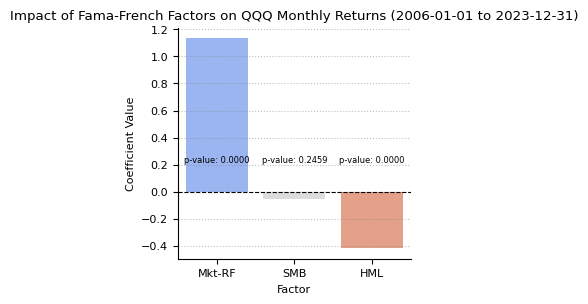

In [16]:
# Step 5.2: Plot the coefficients and their confidence intervals
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

# Create a DataFrame
ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

# Plotting
plt.figure(figsize=(3, 3))
sns.barplot(x="Factor", y="Coefficient", data=ols_data, capsize=0.2, palette="coolwarm")

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        0.2,
        f"p-value: {model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="bottom",
        fontsize=6,
    )

plt.title(f"Impact of Fama-French Factors on {ticker} Monthly Returns ({start_date} to {end_date})")
plt.xlabel("Factor"); plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()